In [1]:
# импорты
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
import sklearn.covariance as cov
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from random import randint
from itertools import combinations

In [2]:
# чтение данных, краткая информация по датафрейму
df = pd.read_pickle('data.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798 entries, 0 to 378
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TVD      1798 non-null   float64
 1   GR       1798 non-null   float64
 2   WNKT     1798 non-null   float64
 3   DTP      1798 non-null   float64
 4   well_id  1798 non-null   object 
 5   DS_diff  835 non-null    float64
dtypes: float64(5), object(1)
memory usage: 98.3+ KB


In [3]:
# вывод заглавных (5) строк таблицы
df.head(5)

,TVD,GR,WNKT,DTP,well_id,DS_diff
0,842.031,10.257,40.069,343.124,UZ-12,NaN
1,842.130,9.947,40.314,339.601,UZ-12,NaN
2,842.228,9.366,40.060,340.717,UZ-12,NaN
3,842.327,8.050,38.385,331.685,UZ-12,NaN
4,842.426,6.654,34.709,308.736,UZ-12,NaN


In [4]:
# удаление колонки DS_diff (анализ проводится по всем скважинам, в том числе с отсутствующим DS_diff параметром)
df.drop(columns=['DS_diff'], inplace=True)

In [5]:
# присваивание простого идентификатора записям, для избежания работы с мультииндексом номер скважины + глубина
vec_func = np.vectorize(lambda x: int(x))
df['id'] = vec_func(np.cumsum(np.ones(len(df))) - 1)

In [6]:
# создание датафрейма с метрическими переменными, по которым будут кластеризовываться данные
metric_df = df.copy()
metric_df.set_index('id', inplace=True)
metric_df.drop(columns=['well_id', 'TVD'], inplace=True)
metric_df.head(5)

,GR,WNKT,DTP
id,,,
0,10.257,40.069,343.124
1,9.947,40.314,339.601
2,9.366,40.060,340.717
3,8.050,38.385,331.685
4,6.654,34.709,308.736


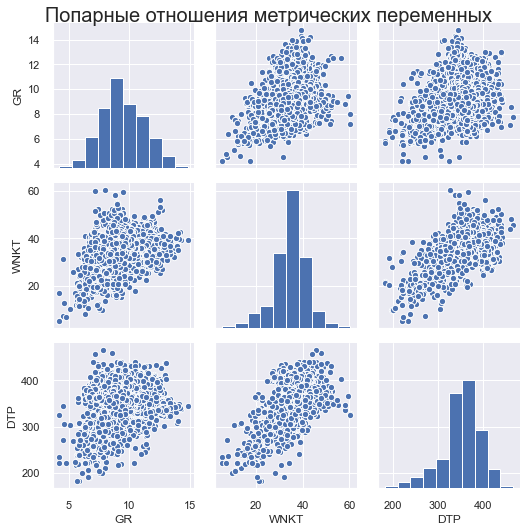

In [7]:
# попарное (две переменных) графическое отображение данных
# по диагонали - диаграммы распределения данных
def pairwise_rel(data):
    sns.set()

    # Setting pairgrid
    g = sns.PairGrid(data)

    # Populating pairgrid
    mdg = g.map_diag(plt.hist, edgecolor="w")
    mog = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Попарные отношения метрических переменных", fontsize=20)

    plt.show()
    
pairwise_rel(metric_df)

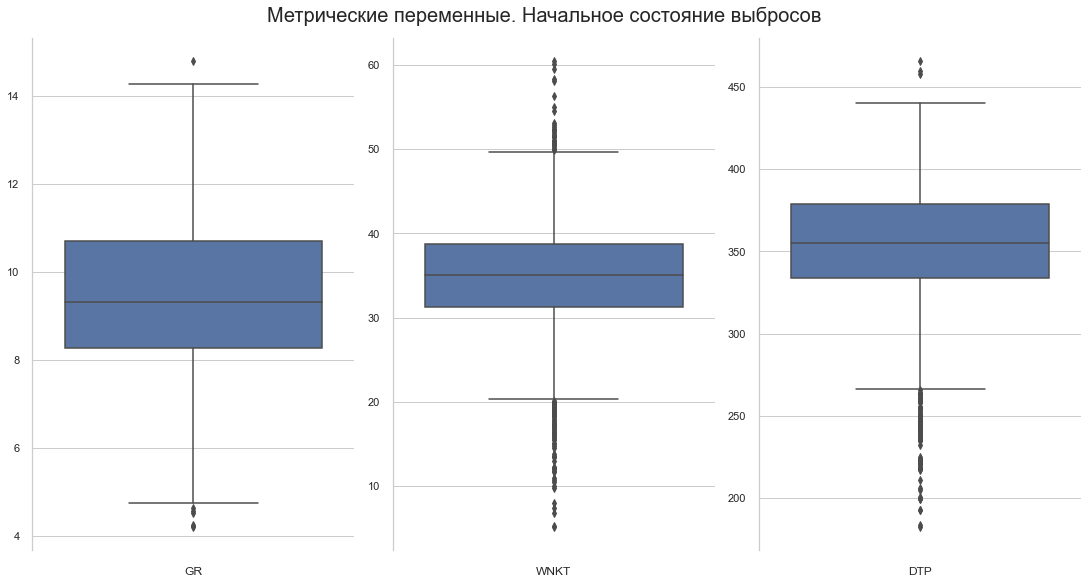

In [8]:
# box plot (ящик с усами) для отображения унивариативных выбросов в датасете (выдросы по каждой переменной отдельно)
def plot_outliers(title, data):
    sns.set(style="whitegrid")

    # Prepare dataframe layout
    plot_features = list(data.columns)

    #Prepare figure layout
    fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)

    # Draw the boxplots
    for i in zip(axes, plot_features):
        sns.boxplot(y=i[1], data=data[[i[1]]], ax=i[0])
        i[0].set_xlabel(i[1])
        i[0].set_ylabel("")

    # Finalize the plot
    plt.suptitle(title, fontsize=20)
    sns.despine(bottom=True)

    plt.show()

plot_outliers("Метрические переменные. Начальное состояние выбросов", metric_df)

In [9]:
# применение преобразования по переменным (featurewise) для приближение распределения значений к гауссовому (нормальному)
# использование двух способов
yj = PowerTransformer(method='yeo-johnson')
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=np.random.RandomState(104))

# трансформация данных
X_trans_yj = yj.fit_transform(metric_df)
X_trans_qt = qt.fit_transform(metric_df)

# объединение данных в единый numpy массив
X_trans = np.concatenate((X_trans_yj, X_trans_qt), axis=1)

# создание объединенного датафрейма
merge_labels = list(map(lambda x: "yj_" + x, metric_df.columns.to_list()))+list(map(lambda x: "qt_" + x,
                    metric_df.columns.to_list()))
trans_df = pd.DataFrame(X_trans, columns=merge_labels, index=metric_df.index)

In [10]:
transqt_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
transyj_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]

In [11]:
# определение выбросов с использованием модели IQR (interquantile range), IQR - межквартильный размах
def out_iqr(data, k=1.5, return_thresholds=False):
    # расчет межквартильного размаха
    q25, q75 = np.percentile(data, 25, axis=0), np.percentile(data, 75, axis=0)
    iqr = q75 - q25
    # расчет границ отсечения
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # идентификация выбросов
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

outlier_labels = pd.concat([out_iqr(transyj_df, 1.2), out_iqr(transqt_df, 1.2)], axis=1)

In [12]:
# мультивариативные выбросы с использованием расстояния Махаланобиса
# основано на IQR, примененном к каждой колонке в отдельности
# мультивариативные выбросы - выбросы сразу по всему набору переменных
def out_mahalanobis(data, random, contamination=0.03):
    n = data.shape[0]
    df = data.shape[1]
    # получение расстояния Махаланобиса от каждого элемента до центра и сортировка по этому расстоянию
    ee_out = cov.EllipticEnvelope(contamination=0.15, support_fraction=0.95, random_state=np.random.RandomState(304)).fit(data)
    mahalan = ee_out.mahalanobis(data)
    # получение альфа-квантиля (персентиля) распределения для каждого элемента
    quantiles = chi2.ppf(q=np.fromfunction(lambda x:(x-0.5)/n, (n,)), df=df)
    # присвоение меток каждому элеменнту
    labels = ee_out.predict(data)
    
    return mahalan, quantiles, labels

mqt, qqt, lqt = out_mahalanobis(transqt_df, 0)
myj, qyj, lyj = out_mahalanobis(transyj_df, 0)
lqt_lyj = pd.DataFrame({'lqt': lqt, 'lyj': lyj})

In [13]:
# проверка процента выбросов
inl = lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1)].sum()['lqt']
'Процент выбросов: {:4.2f}%'.format(100 - inl/len(lqt_lyj) * 100)

'Процент выбросов: 17.02%'

In [14]:
# создание маски для исключения выбросов из таблицы
lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1), 'mask'] = True
lqt_lyj.fillna(False, inplace=True)
lqt_lyj.drop(columns=['lqt', 'lyj'], inplace=True)

In [15]:
# установка маски
main_data = metric_df.merge(lqt_lyj, left_index=True, right_index=True)
try:
    cleaned_data = main_data.loc[main_data['mask'] == True].copy()  
except:
    print('Маска не была установлена')

In [16]:
# удаление колонки маски в очищенном от выбросов датафрейме
cleaned_data.drop(columns=['mask'], inplace=True)

In [17]:
# определение количества удаленных измерений
rows_after_iqr = len(cleaned_data)
print("Количество строк после удаления выбросов", rows_after_iqr)
print("Удалено {} измерений".format(len(df) - len(cleaned_data)))

Количество строк после удаления выбросов 1492
Удалено 306 измерений


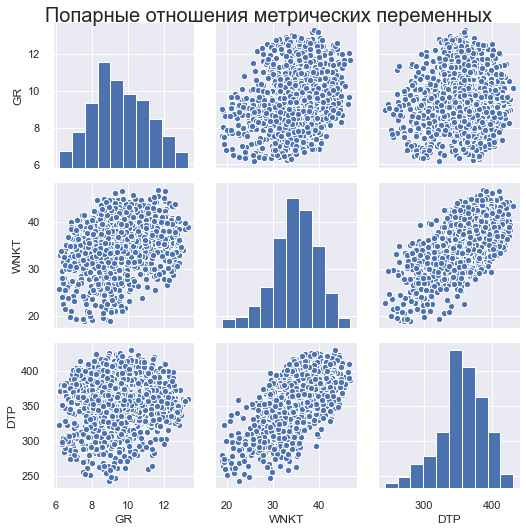

In [18]:
# графическое отображения попарных отношений переменных после удаления выбросов
pairwise_rel(cleaned_data)

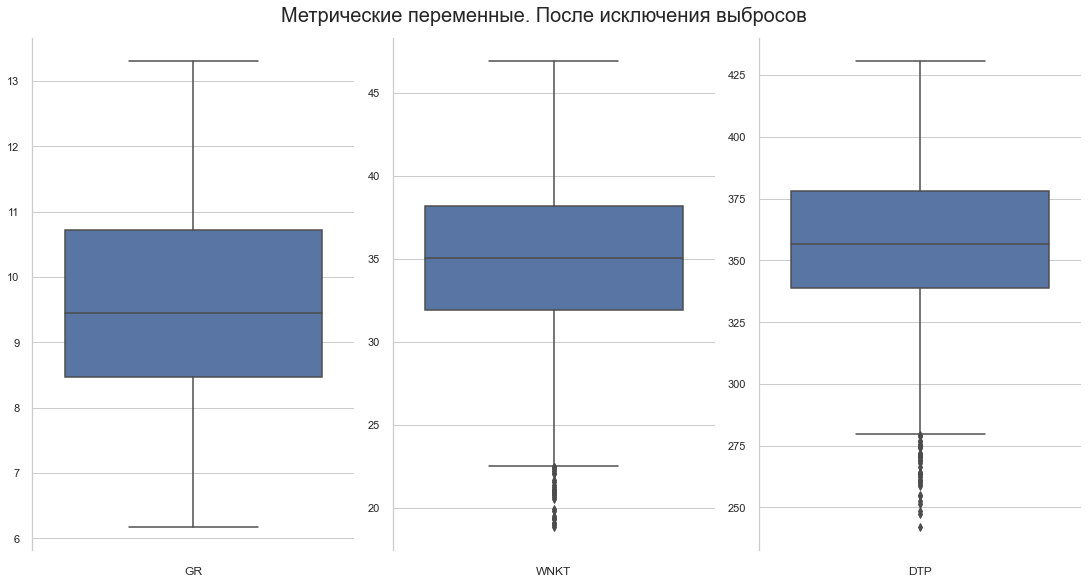

In [19]:
plot_outliers("Метрические переменные. После исключения выбросов", cleaned_data)

In [20]:
# метод построения матрицы корреляции
def plot_corr_matrix(metric_df, abs_apply=False, values=False, fig_size = (7, 7)):    
    sns.set(style="white")

    # расчет корреляционной матрицы с использованием pandas
    corr = metric_df.corr()
    if abs_apply == True:
        corr = corr.apply(np.abs)
    
    # генерация маски для верхнего треугольника
    mask = np.zeros_like(corr, dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True

    # создание экземпляра класса matplotlib figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Генерация карты цветов 
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
        
    # Отображение HeatMap и коррекция масштаба
    if values:
        mask_annot = np.absolute(corr.values)>=0.70
        annot_arr = np.where(mask_annot, corr.values.round(2), np.full(fig_size,""))
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax, annot=annot_arr, fmt="s")
    else:
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

    # отображение фигуры matplotlib
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Матрица корреляции", fontsize=20)
    plt.yticks(rotation=0)
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)

    plt.show()

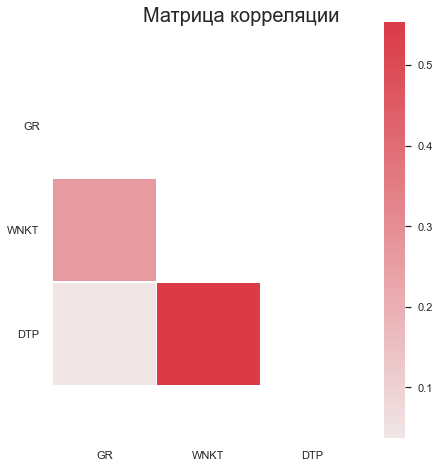

In [21]:
plot_corr_matrix(cleaned_data)

In [22]:
# метод отображения K-elbowplot: метрика кластеризации
def kelbowplots(clus_estim, data):
    """
    Метод отображает три метрики: "Distortion", "Silhouette" and "Calinski Harabasz"
    для различного количества кластеров с использованием заданной модели clust_estim
    """
    sns.set()
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    # построение
    metrics = ["distortion", "silhouette", "calinski_harabasz"]
    ylabels = ["Distortion measure", "Silhouette measure", "Calinski Harabasz measure"]
    titles = ["Distortion measure plot", "Silhouette measure plot", "Calinski Harabasz measure plot"]
    for ax, m, yl, tl in zip(axes.flatten(), metrics, ylabels, titles):
        KElbowVisualizer(clus_estim, metric=m, timings=False, locate_elbow=False, ax=ax).fit(data)
        ax.invert_xaxis()
        ax.set_ylabel(yl, fontsize=13)
        ax.set_xlabel("Количество кластеров", fontsize=13)
        ax.set_title(tl, fontsize=13)

    plt.suptitle("Графики K-Elbow", fontsize=20)

    plt.show()

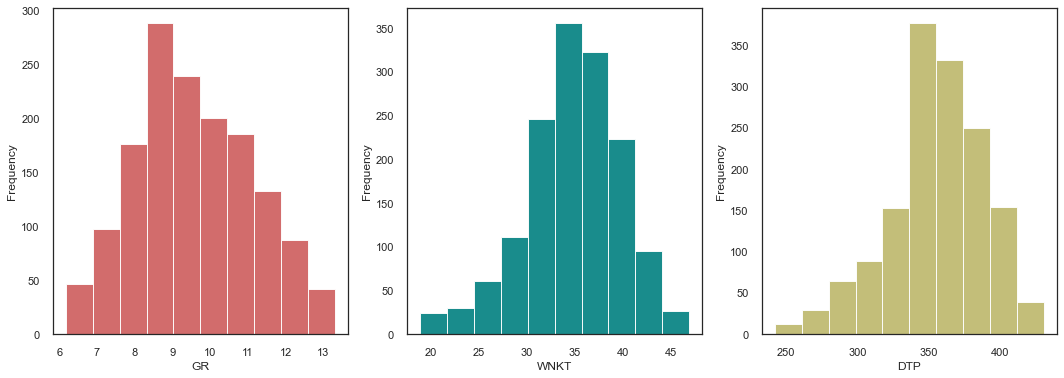

In [23]:
# проверка типа распределения данных (по переменным, columnwise) перед кластеризацией
fig, axes = plt.subplots(1, 3, figsize=(18,6))
for col, ax, color in zip(cleaned_data, axes, ['indianred', 'teal', 'darkkhaki']):
    cleaned_data[col].plot.hist(ax=ax, alpha=0.9, color=color)
    ax.set_xlabel(col)
plt.show()

In [24]:
# номировка данных, т.к. необходимо чтобы все параметры (переменные) имели одинаковую важность
scaler = StandardScaler()
std_df = pd.DataFrame(scaler.fit_transform(cleaned_data), index=cleaned_data.index, columns=cleaned_data.columns)

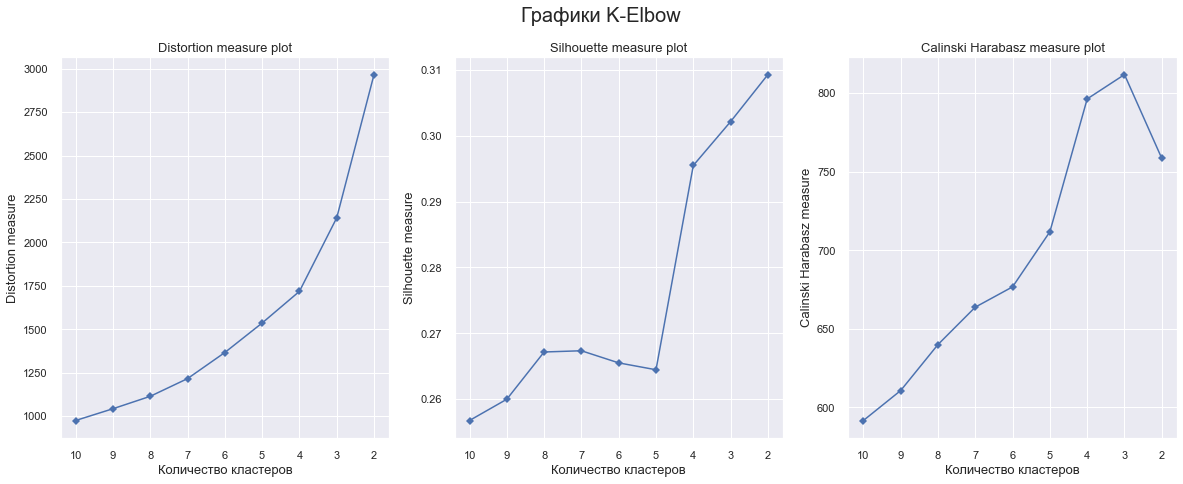

In [25]:
# инициализация K-Means модели
clus_estim = KMeans(random_state=0)

# построение K-elbow
kelbowplots(clus_estim, std_df)

In [26]:
# определение кластеров с использованием модели K-Means
def make_clusters(n_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
    df_res = std_df.copy()
    df_res['cluster'] = kmeans.fit_predict(np.array(std_df))
    return df_res

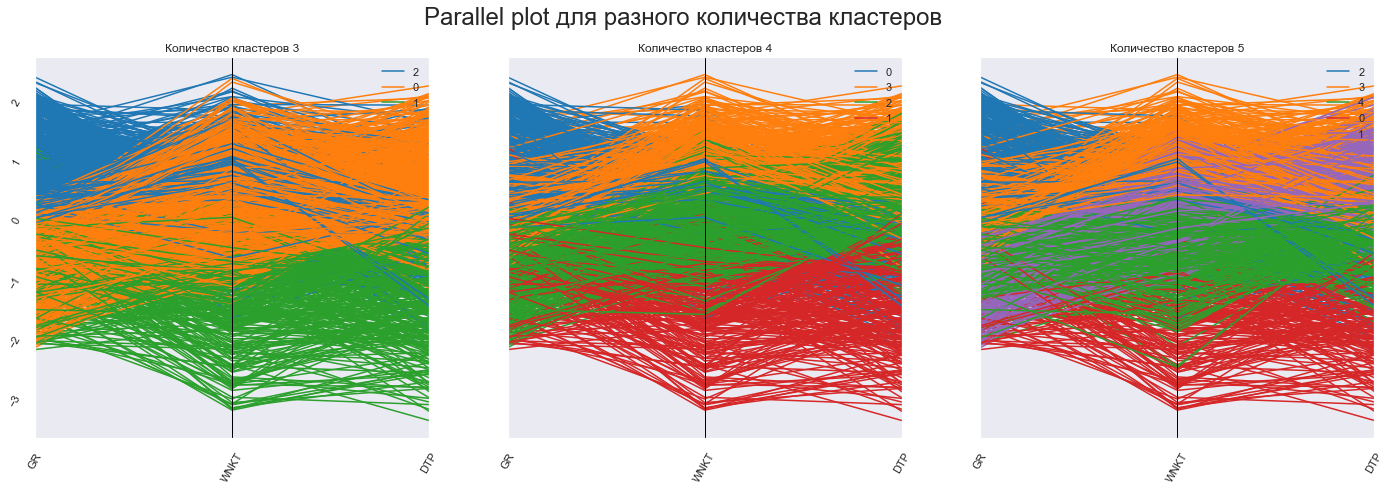

In [27]:
# parallel plot для разного количества кластеров
from matplotlib import colors as mcolors

f, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(24, 7))
for i, ax in zip(range(3, 6), axs.flatten()):
    df_res = make_clusters(i)
    pd.plotting.parallel_coordinates(df_res, 'cluster', color=list(mcolors.TABLEAU_COLORS.values()), ax=ax)
    ax.tick_params(labelrotation=60)
    ax.set_title('Количество кластеров ' + str(i))

plt.suptitle("Parallel plot для разного количества кластеров", fontsize=24)
plt.show()

In [28]:
#K means кластеризация
def doKmeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [29]:
# кластеризация с использованием K-Means в 4 кластера
clust_labels, cent = doKmeans(std_df, 4)
kmeans_std_df = std_df.copy()
kmeans_std_df["kmeans_labels"] = clust_labels

X = np.array(std_df)

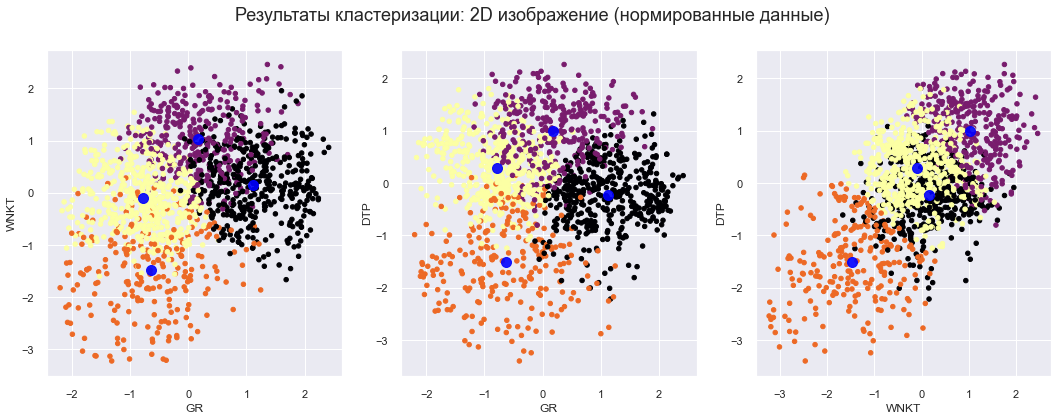

In [30]:
# scatter plot для полученной кластеризации
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, var_pair in zip(axes, pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clust_labels, s = 20, cmap = 'inferno')
    ax.scatter(cent.T[list(std_df.columns).index(var_pair[0])], cent.T[list(std_df.columns).index(var_pair[1])],
               c = 'blue', s = 100, alpha = 0.9)
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (нормированные данные)', fontsize=18)
plt.show()

In [31]:
# присвоение кластерных меток измерения начальной таблицы, очищенной от выбросов
# восстановление индексации
cleaned_data['cluster'] = clust_labels
clusterized = cleaned_data.merge(df[['well_id', 'TVD', 'id']], left_index=True, right_on='id')

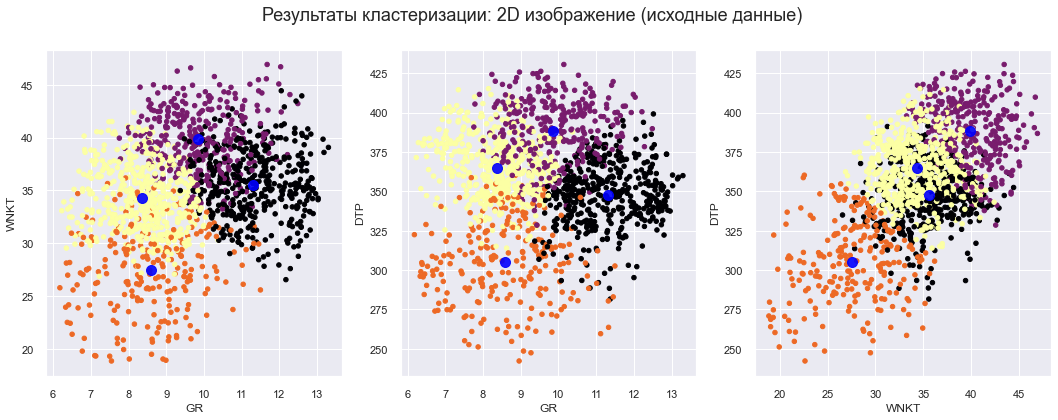

In [32]:
# scatter plot для полученной кластеризации
pairs = combinations(clusterized[std_df.columns], 2)
original_centroids = scaler.inverse_transform(cent)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, var_pair in zip(axes, pairs):
    ax.scatter(clusterized[std_df.columns][var_pair[0]], clusterized[std_df.columns][var_pair[1]],
               c = clust_labels, s = 20, cmap = 'inferno')
    ax.scatter(original_centroids.T[list(std_df.columns).index(var_pair[0])],
               original_centroids.T[list(std_df.columns).index(var_pair[1])],
              c = 'blue', s = 100, alpha = 0.9)
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение (исходные данные)', fontsize=18)
plt.show()

In [33]:
# проверка - отображение заглавных строк полученной объединением таблицы
clusterized.head(5)

,GR,WNKT,DTP,cluster,well_id,TVD,id
0,10.257,40.069,343.124,0,UZ-12,842.031,0
1,9.947,40.314,339.601,0,UZ-12,842.130,1
2,9.366,40.060,340.717,1,UZ-12,842.228,2
3,8.050,38.385,331.685,3,UZ-12,842.327,3
4,6.654,34.709,308.736,2,UZ-12,842.426,4


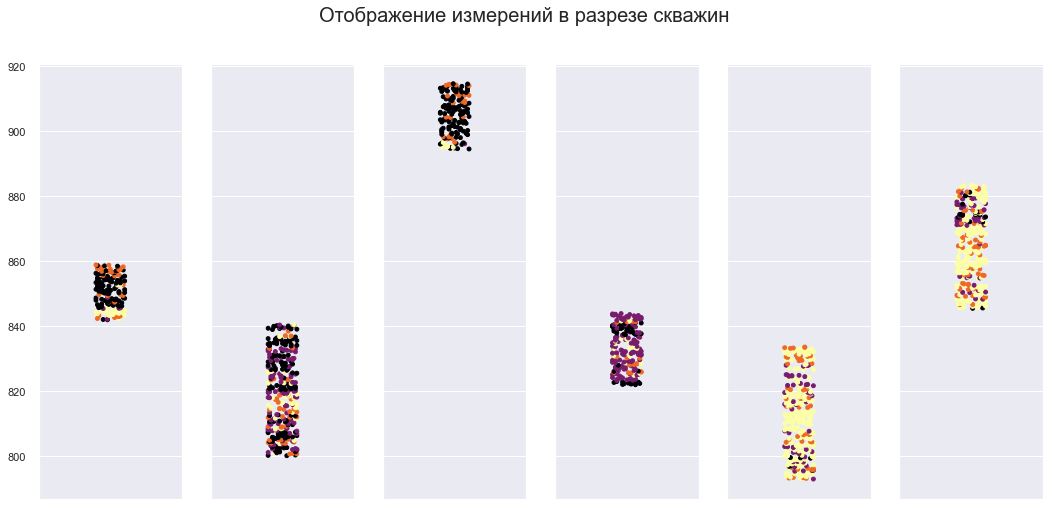

In [34]:
# отображение измерений в разрезе скважин

# параметр ширины отображения скважины (доля от диапазона оси X)
k = 0.2

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 6))

fig, axes = plt.subplots(n_rows, 6, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well.cluster, s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Отображение измерений в разрезе скважин', fontsize=20)
plt.show()

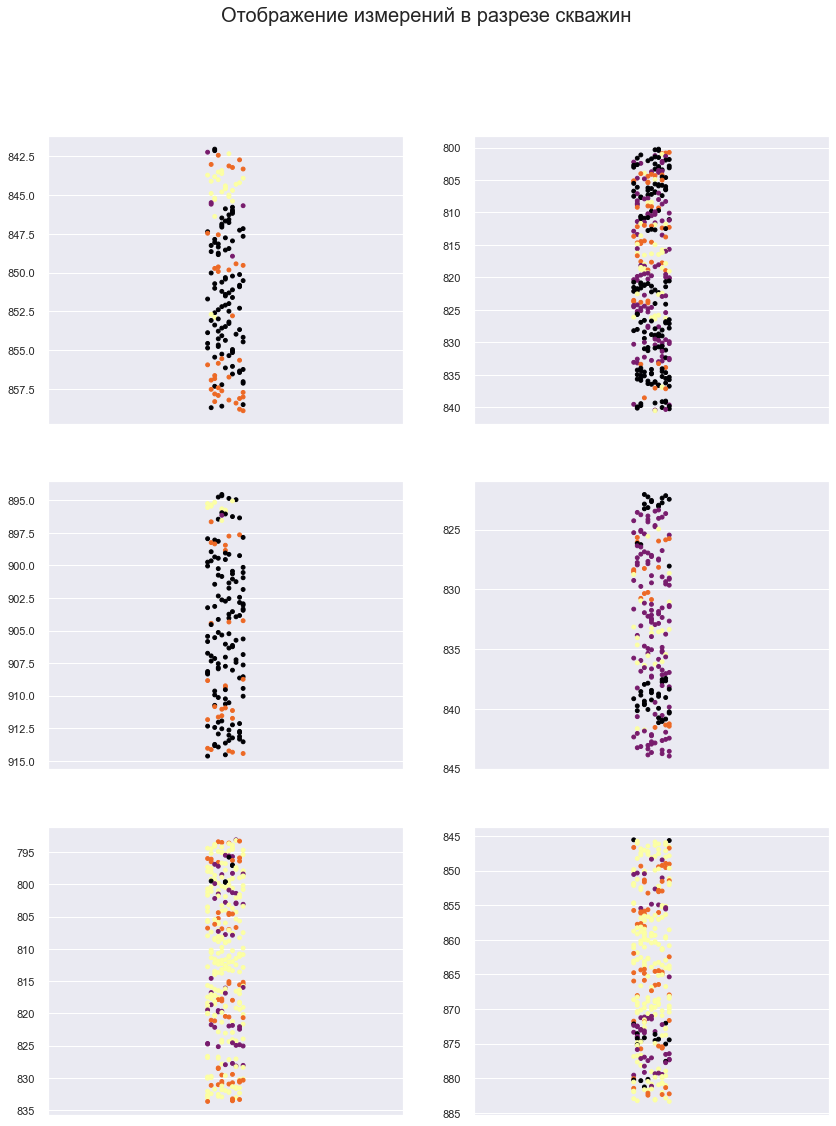

In [35]:
# отображение измерений в разрезе скважин - укрупненное

# параметр ширины отображения скважины (доля от диапазона оси X)
k = 0.1

n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 2))

fig, axes = plt.subplots(n_rows, 2, figsize=(14, 6 * n_rows))
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(int(50 - 100 * k/2), int(50 + 100 * k/2)) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well.cluster, s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    ax.invert_yaxis()
    ax.set_xticks([])
plt.suptitle('Отображение измерений в разрезе скважин', fontsize=20)
plt.show()

In [36]:
clusterized.drop(columns=['id'], inplace=True)
clusterized.to_excel('full_data_clusterized.xlsx')